<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Mood_Detection_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Select TensorFlow 2.0 environment
%tensorflow_version 2.x

In [0]:
# Google Colab imports for setting up Kaggle
from google.colab import files
files.upload()

In [0]:
# Set up Kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
# Download the data
# https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

In [0]:
# Unzip dataset
!unzip icml_face_data.csv.zip
!unzip test.csv.zip
!unzip train.csv.zip

In [0]:
!tar xvf fer2013.tar.gz

In [0]:
# General imports
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Load up the training dataset
train = pd.read_csv("train.csv")
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [13]:
# Class distribution
train["emotion"].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

Class imbalance noticed.

In [4]:
# Load test dataset
test = pd.read_csv("test.csv")
test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


Note on the label mapping:

(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [0]:
# Function to clean the dataset
# Taken from http://bit.ly/37AUk7f
def clean_data(dataframe):
    image_pixels = np.zeros(shape=(len(dataframe), 48, 48))
    labels = np.zeros(shape=(len(dataframe), ))
    for (i, row) in tqdm(dataframe.iterrows()):
        image = np.fromstring(row["pixels"], dtype=int, sep=' ')
        image = image.reshape(48, 48)
        image = image.astype("float")/255
        
        image_pixels[i] = image
        labels[i] = row["emotion"]
    
    return (image_pixels, labels)

In [36]:
# Clean the training dataset and verify the shapes
(train_pixels, train_labels) = clean_data(train)
train_pixels.shape, train_labels.shape

28709it [00:05, 4943.14it/s]


((28709, 48, 48), (28709,))

In [0]:
# sklearn and other utility imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [0]:
# One-hot encode the labels
le = LabelEncoder().fit(train_labels)
train_labels = to_categorical(le.transform(train_labels), 7)

In [39]:
train_labels.shape

(28709, 7)

In [40]:
# Split the training data into further partial training and validation data
(trainX, valX, trainY, valY) = train_test_split(train_pixels,
    train_labels, test_size=0.15, stratify=train_labels, random_state=42)
trainX.shape, trainY.shape, valX.shape, valY.shape

((24402, 48, 48), (24402, 7), (4307, 48, 48), (4307, 7))

In [0]:
# Account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [0]:
# Define the label mapping
LABELS = {
    0: "Angry", 
    1: "Disgust", 
    2: "Fear",
    3: "Happy", 
    4: "Sad", 
    5: "Surprise", 
    6: "Neutral"
}

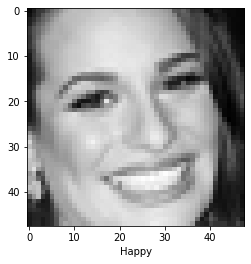

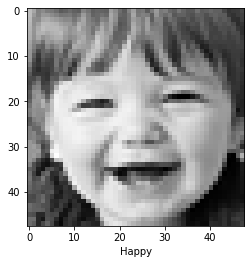

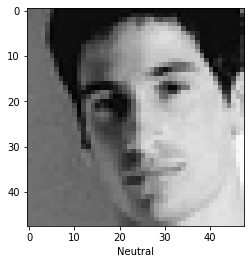

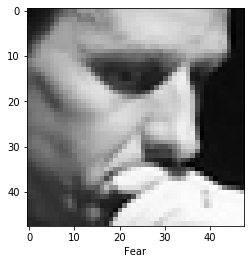

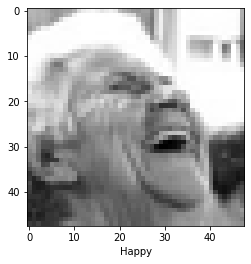

In [52]:
# Spot check the dataset
train_idx = np.random.choice(len(trainX), 5)
for id in train_idx:
    plt.imshow(trainX[id], cmap="gray")
    plt.xlabel(LABELS[np.argmax(trainY[id])])
    plt.show()

In [42]:
# Comes from http://bit.ly/2U8ntCX
!wget https://raw.githubusercontent.com/sayakpaul/ML-Bootcamp-Launchpad/master/pyimagesearch/models.py

--2020-01-30 15:58:46--  https://raw.githubusercontent.com/sayakpaul/ML-Bootcamp-Launchpad/master/pyimagesearch/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5217 (5.1K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   5.09K  --.-KB/s    in 0s      

2020-01-30 15:58:46 (111 MB/s) - ‘models.py’ saved [5217/5217]



In [0]:
# PyImageSearch imports
from models import MiniVGGNetModel
from models import minigooglenet_functional
from models import shallownet_sequential

In [0]:
# Convnets would require a channel dimension
trainX = trainX.reshape(-1, 48, 48, 1)
valX = valX.reshape(-1, 48, 48, 1)

In [0]:
# Set up wandb
!pip install wandb
!wandb login

In [58]:
# Import wandb
import wandb
from wandb.keras import WandbCallback

W&B Run: https://app.wandb.ai/pcg/uncategorized/runs/vh5ao1pi

In [64]:
# Train our first shallow model
wandb.init(project="emotion-detection", entity="sayakpaul", id="shallow-convnet")
shallow_model = shallownet_sequential(48, 48, 1, len(LABELS))
shallow_model.compile(loss="categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"])
shallow_model.fit(trainX, trainY,  validation_data=(valX, valY), epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", labels=LABELS)])

Train on 24402 samples, validate on 4307 samples
Epoch 1/50
 2208/24402 [=>............................] - ETA: 5s - loss: 1.9817 - accuracy: 0.2446

Streaming file created twice in same run: /content/wandb/run-20200130_163754-shallow-convnet/wandb-history.jsonl
Streaming file created twice in same run: /content/wandb/run-20200130_163754-shallow-convnet/wandb-events.jsonl


24402/24402 [==============================] - 4s 184us/sample - loss: 1.6673 - accuracy: 0.3485 - val_loss: 1.5735 - val_accuracy: 0.3880
Epoch 2/50
24402/24402 [==============================] - 4s 168us/sample - loss: 1.4426 - accuracy: 0.4557 - val_loss: 1.4882 - val_accuracy: 0.4321
Epoch 3/50
24402/24402 [==============================] - 4s 161us/sample - loss: 1.2931 - accuracy: 0.5198 - val_loss: 1.5416 - val_accuracy: 0.4256
Epoch 4/50
24402/24402 [==============================] - 4s 168us/sample - loss: 1.1617 - accuracy: 0.5756 - val_loss: 1.5208 - val_accuracy: 0.4370
Epoch 5/50
24402/24402 [==============================] - 4s 162us/sample - loss: 1.0431 - accuracy: 0.6218 - val_loss: 1.5323 - val_accuracy: 0.4451
Epoch 6/50
24402/24402 [==============================] - 4s 161us/sample - loss: 0.9317 - accuracy: 0.6646 - val_loss: 1.5964 - val_accuracy: 0.4572
Epoch 7/50
24402/24402 [==============================] - 4s 149us/sample - loss: 0.8251 - accuracy: 0.7113 - v

In [68]:
# Train a mini inception net
wandb.init(project="emotion-detection", entity="sayakpaul", id="miniinception-net")
inception_net = minigooglenet_functional(48, 48, 1, len(LABELS))
inception_net.compile(loss="categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"])
inception_net.fit(trainX, trainY,  validation_data=(valX, valY), epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", labels=LABELS)])

Train on 24402 samples, validate on 4307 samples
Epoch 1/50
24402/24402 [==============================] - 43s 2ms/sample - loss: 1.6572 - accuracy: 0.3435 - val_loss: 1.7642 - val_accuracy: 0.3267
Epoch 2/50
24402/24402 [==============================] - 40s 2ms/sample - loss: 1.3076 - accuracy: 0.5072 - val_loss: 1.3814 - val_accuracy: 0.4920
Epoch 3/50
24402/24402 [==============================] - 39s 2ms/sample - loss: 1.1605 - accuracy: 0.5659 - val_loss: 1.2983 - val_accuracy: 0.5322
Epoch 4/50
24402/24402 [==============================] - 40s 2ms/sample - loss: 1.0827 - accuracy: 0.5963 - val_loss: 1.3843 - val_accuracy: 0.4720
Epoch 5/50
24402/24402 [==============================] - 39s 2ms/sample - loss: 1.0127 - accuracy: 0.6212 - val_loss: 1.1418 - val_accuracy: 0.5723
Epoch 6/50
24402/24402 [==============================] - 39s 2ms/sample - loss: 0.9470 - accuracy: 0.6471 - val_loss: 1.1470 - val_accuracy: 0.5719
Epoch 7/50
24402/24402 [==============================] -

In [69]:
# Train a mini VGG net
wandb.init(project="emotion-detection", entity="sayakpaul", id="mini-vgg-net")
vgg_net = MiniVGGNetModel(len(LABELS))
vgg_net.compile(loss="categorical_crossentropy", optimizer="adam",
	metrics=["accuracy"])
vgg_net.fit(trainX, trainY,  validation_data=(valX, valY), epochs=50,
    class_weight=classWeight,
    callbacks=[WandbCallback(data_type="image", labels=LABELS)])

Train on 24402 samples, validate on 4307 samples
Epoch 1/50
24320/24402 [============================>.] - ETA: 0s - loss: 1.8313 - accuracy: 0.3616

wandb: ERROR Can't save model, h5py returned error: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.


24402/24402 [==============================] - 8s 332us/sample - loss: 1.8301 - accuracy: 0.3620 - val_loss: 1.4815 - val_accuracy: 0.4272
Epoch 2/50
24402/24402 [==============================] - 7s 278us/sample - loss: 1.3966 - accuracy: 0.4711 - val_loss: 1.5134 - val_accuracy: 0.4367
Epoch 3/50
24402/24402 [==============================] - 7s 279us/sample - loss: 1.2637 - accuracy: 0.5229 - val_loss: 1.3126 - val_accuracy: 0.5043
Epoch 4/50
24402/24402 [==============================] - 7s 284us/sample - loss: 1.1870 - accuracy: 0.5486 - val_loss: 1.4100 - val_accuracy: 0.4927
Epoch 5/50
24402/24402 [==============================] - 7s 280us/sample - loss: 1.1187 - accuracy: 0.5813 - val_loss: 1.2418 - val_accuracy: 0.5329
Epoch 6/50
24402/24402 [==============================] - 7s 279us/sample - loss: 1.0481 - accuracy: 0.6068 - val_loss: 1.5332 - val_accuracy: 0.4627
Epoch 7/50
24402/24402 [==============================] - 7s 278us/sample - loss: 0.9845 - accuracy: 0.6335 - v